In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from rlway.pyosrd.osrd import OSRD

In [106]:
sim = OSRD(use_case='point_switch', dir='tmp')

[17:31:51,135] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[17:31:51,167] [INFO]              [FullInfra] parsing infra
[17:31:51,229] [INFO]              [FullInfra] adaptation to kotlin
[17:31:51,261] [INFO]              [FullInfra] loading signals
[17:31:51,267] [INFO]              [FullInfra] building blocks
[17:31:51,271] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[17:31:51,285] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.6
[17:31:51,334] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.7
[17:31:51,339] [INFO]  [StandaloneSimulationCommand] All simulations completed
[17:31:51,339] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json


In [107]:
!mkdir -p tmp/disturbed
!mkdir -p tmp/disturbed/regulated

In [108]:
from copy import copy
import json
import os

disturbed = copy(sim)
disturbed.simulation_json='disturbed/simulation.json'
disturbed.results_json='disturbed/results.json'
!mkdir -p tmp/disturbed
disturbed.simulation['train_schedule_groups'][0]['schedules'][0]['stops']+=[{'duration': 5*60, 'position': 130}]
with open(os.path.join(disturbed.dir, disturbed.simulation_json), "w") as outfile:
    json.dump(disturbed.simulation, outfile)
disturbed.run()


regulated = copy(disturbed)
regulated.simulation_json='disturbed/regulated/simulation.json'
regulated.results_json='disturbed/regulated/results.json'
!mkdir -p tmp/disturbed/regulated
regulated.simulation['train_schedule_groups'][1]['schedules'][0]['stops']+=[{'duration': 3*60, 'position': 0.1}]
with open(os.path.join(regulated.dir, regulated.simulation_json), "w") as outfile:
    json.dump(regulated.simulation, outfile)
regulated.run()

[17:31:52,219] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[17:31:52,249] [INFO]              [FullInfra] parsing infra
[17:31:52,308] [INFO]              [FullInfra] adaptation to kotlin
[17:31:52,339] [INFO]              [FullInfra] loading signals
[17:31:52,345] [INFO]              [FullInfra] building blocks
[17:31:52,349] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/disturbed/simulation.json
[17:31:52,361] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.6
[17:31:52,408] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.7
[17:31:52,413] [INFO]  [StandaloneSimulationCommand] All simulations completed
[17:31:52,414] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/disturbed/results.json
[17:31:52,892] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[17:31:52,923] [INFO]              [FullInfra] parsing infra
[17:31:52,981] [INFO]              [FullIn

<Axes: title={'center': 'train1 (base)'}, xlabel='Time [min]'>

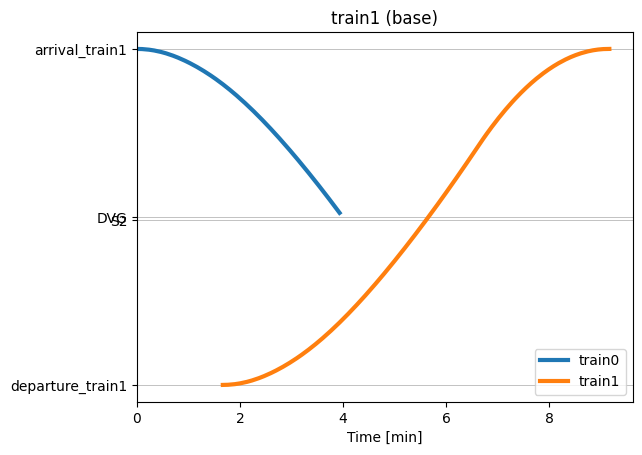

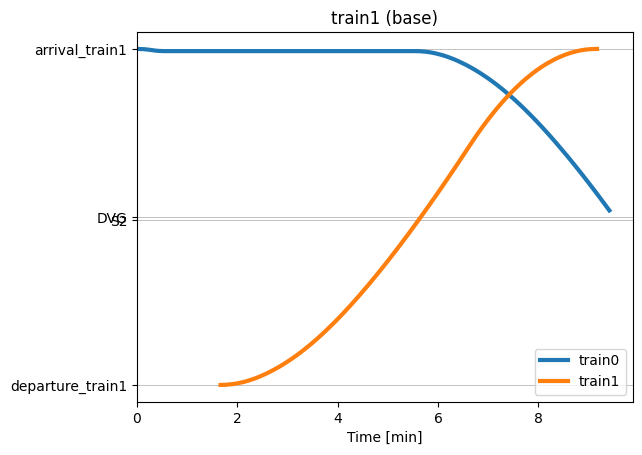

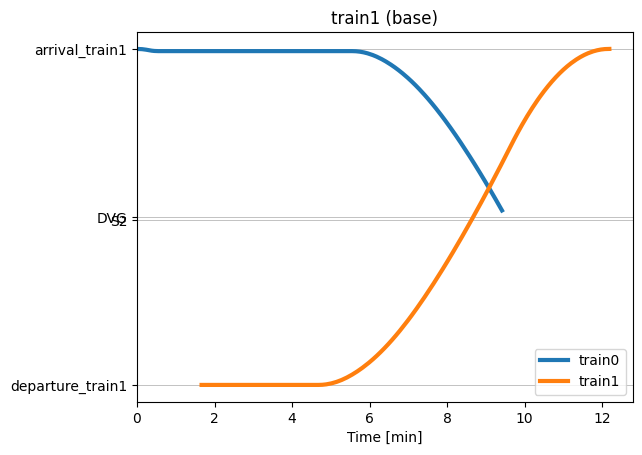

In [109]:
import matplotlib.pyplot as plt
points_to_show=['switch', 'signal', 'departure', 'switch', 'arrival']
sim.space_time_graph(1, points_to_show=points_to_show)
disturbed.space_time_graph(1, points_to_show=points_to_show)
regulated.space_time_graph(1, points_to_show=points_to_show)